In [2]:
import meshplot as mp 
import igl 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
import os
import shapely
from shapely.geometry import Point
from shapely.geometry import Polygon, mapping
from shapely.geometry.polygon import Polygon
import sympy
#from sympy import Point,Line#,Polygon


**Defining the 3d cylindrical mesh**

N = Number of unit meshes along a radii
r = splitting N radiis of OD - ID (43-18)
thetasteps = number of lines split among 360 degree 
z_steps= number of depth elements in z 
z= Depth elements devided for 60mm 
nodes= contains all cordinates required for the mesh 
e_list= contains 8 tuple nodes defining a rectangular mesh 

In [3]:
Insert_config='circle'
N= 17
IR=15
OR=50
r= np.linspace(IR, OR, N)
thetasteps= 72
dt=2*np.pi/thetasteps
theta=  np.linspace(0, 2*np.pi-dt, thetasteps)

z_steps= 21
z=np.linspace(0,60,z_steps)

z_count=1
count=1

nodes=[]


for i in range(z_steps):
    for j in range(N):
        for k in range(thetasteps):
            nodes.append([count,
                                r[j]*np.cos(theta[k]),
                                r[j]*np.sin(theta[k]),
                                z[i]])
            count=count+1
               

e_list=[]
            

for m in range(0,z_steps-1):
    lis=np.arange(1+m*thetasteps*N,(m+1)*thetasteps*N-thetasteps+1,1)
    #print(len(lis),lis)
    for g in range(len(lis)):
        if lis[g]%thetasteps==0:
            #print(lis[g])
            n= int(lis[g]/thetasteps)
            e_list.append([z_count, 
                                lis[g], 
                                (lis[g]+1)%thetasteps +(n-1)*thetasteps, 
                                (lis[g]+thetasteps+1)%thetasteps+n*thetasteps, 
                                lis[g]+thetasteps,
                                lis[g]+ (N*thetasteps), 
                                (lis[g]+1)%thetasteps +(n-1)*thetasteps+ (N*thetasteps),
                                (lis[g]+thetasteps+1)%thetasteps+n*thetasteps+ (N*thetasteps), 
                                lis[g]+thetasteps + (N*thetasteps)])

        else:
            e_list.append([z_count, 
                                lis[g], 
                                (lis[g]+1), 
                                (lis[g]+thetasteps+1), 
                                lis[g]+thetasteps,
                                lis[g]+ (N*thetasteps), 
                                (lis[g]+1)+ (N*thetasteps),
                                (lis[g]+thetasteps+1)+ (N*thetasteps), 
                                lis[g]+thetasteps + (N*thetasteps)])
        z_count=z_count+1

#print(r)
        
#print(e_list) 




In [4]:
#visualizing all point on a 2d cross-section 

#X=[item[1] for item in nodes]
#Y=[item[2] for item in nodes] 
#Z=[item[3] for item in nodes]
#plt.scatter(X,Y,s=3,color="red")


#selecting nodes and coordinates on the front facing 2d cross-section and appending them to a list "ele"
ele=np.zeros(shape=(len(e_list),5,2))

for i in range(len(e_list)):
    ele[i]=[[nodes[e_list[i][1]-1][1],nodes[e_list[i][1]-1][2]],
              [nodes[e_list[i][2]-1][1],nodes[e_list[i][2]-1][2]],
              [nodes[e_list[i][3]-1][1],nodes[e_list[i][3]-1][2]],
              [nodes[e_list[i][4]-1][1],nodes[e_list[i][4]-1][2]],
              [nodes[e_list[i][1]-1][1],nodes[e_list[i][1]-1][2]]]
    #xs, ys = zip(*ele[i])
    #plt.plot(xs,ys,color='blue') 

    
plt.rcParams['figure.figsize'] = [40, 40]

#visualizing the 2d cross section with elements 
plt.show()



**Metal area defined**
Deafult configuration where the outermost radiie consist of metal 

- relevant metal node numbers are appended to a list 'metal'

In [7]:
##
#%matplotlib

def polar1(x, y):
    """returns r, theta(degrees)
    """
    rads = (x ** 2 + y ** 2) ** .5
    theta_1 = math.degrees(math.atan2(y,x))
    theta_1 = (theta_1 + 360) % 360
    return round(rads,1), round(theta_1,2)

#List to note metal node numbers  
metal=[]

'''
for i in range(len(ele)):
    counter=0
    counter1=0
    for j in range(4):
        radius,angle=(polar1(ele[i][j][0],ele[i][j][1]))
        if(round(radius,1)>=round(r[-2],1)
           and round(radius,1) <= round(r[-1],1) 
           and round((angle),1) >= round(math.degrees(theta[0]),1) 
           and round((angle),1) <= round(math.degrees(theta[-1]),1)):
            counter=counter+1
        if(counter==4):
            rx,ry=zip(*ele[i])
            metal.append(i)
            plt.plot(rx,ry,color='black')
'''

for i in range(len(ele)):
    radius,angle=(polar1(ele[i][0][0],ele[i][0][1]))
    if(round(radius,1) == round(r[-2],1)): #and round(radius,1) <= round(r[-1],1) 
        metal.append(i)
            


            


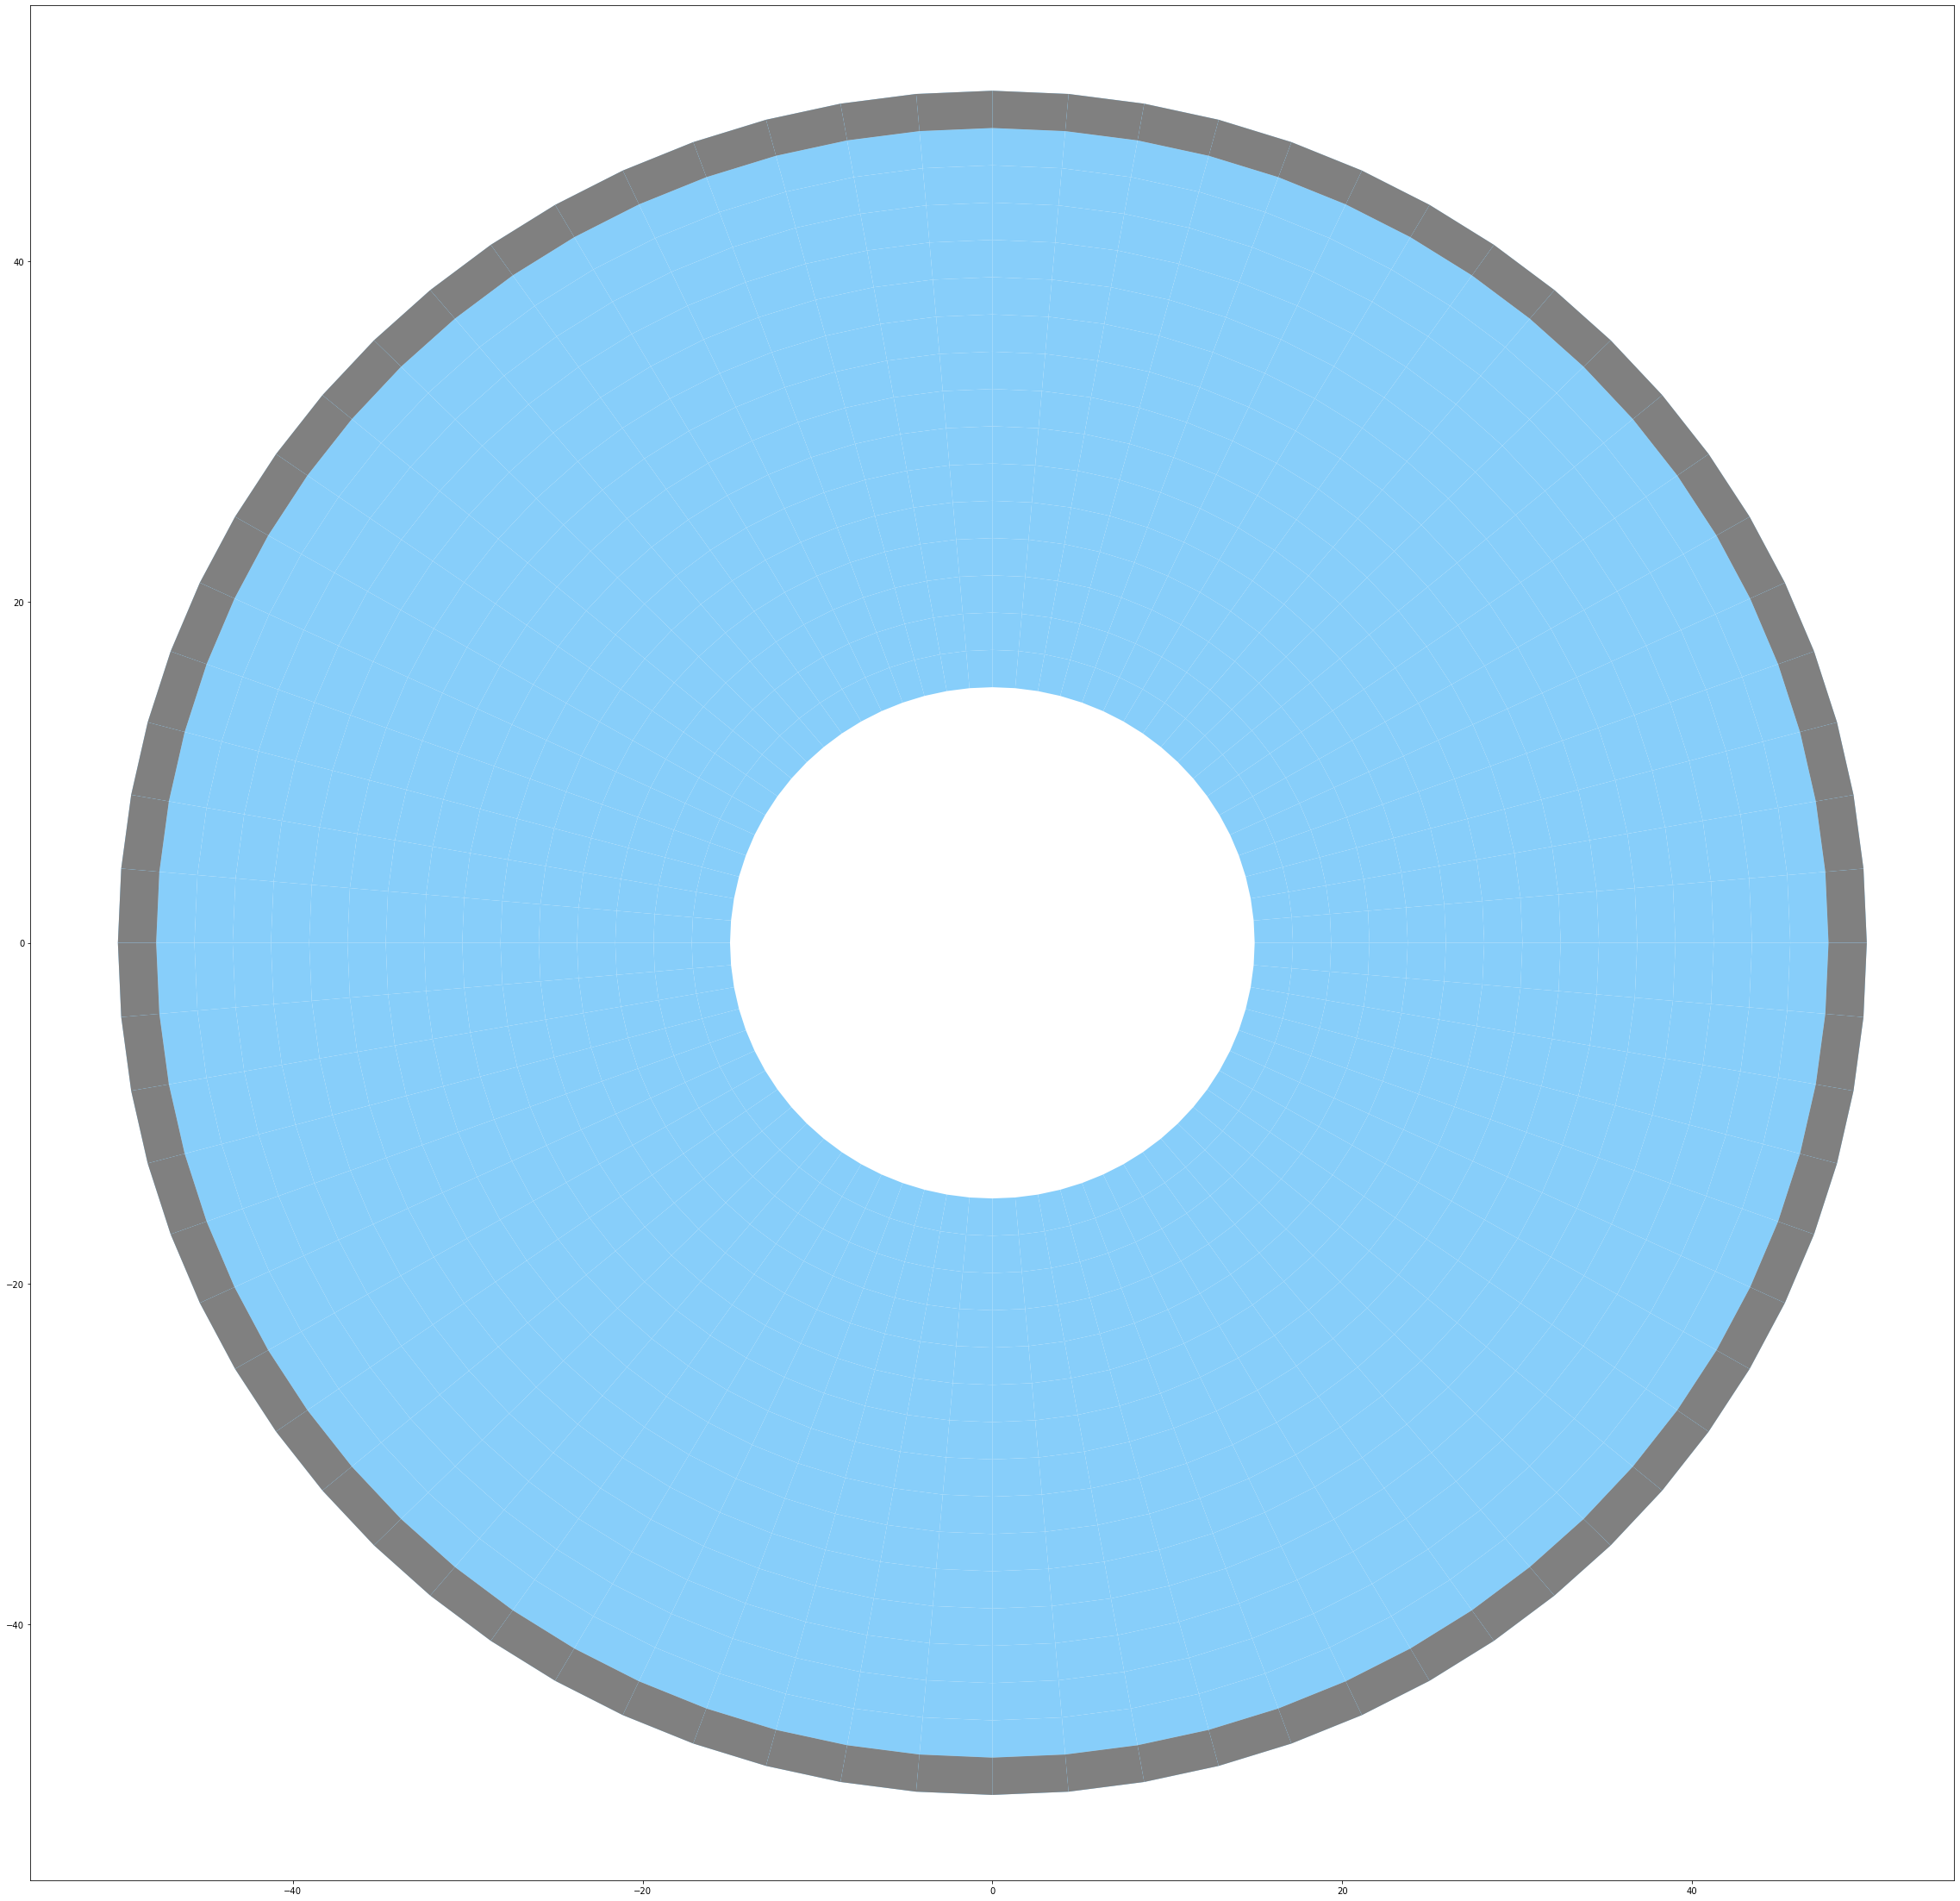

In [8]:
for i in range(((N-1)*thetasteps)):
    xs,ys=zip(*ele[i])
    #plt.plot(xs,ys,color='red')
    plt.fill(xs, ys, "lightskyblue")   
    #if(i in rubber):
    #    xs,ys=zip(*ele[i])
    #    plt.fill(xs, ys, "darksalmon")
    if(i in metal):
        xs,ys=zip(*ele[i])
        plt.fill(xs, ys, "gray")
        #plt.plot(xs,ys)

**The type of insert is mentioned # 1= Diamond, 2= Bezier diamond, 3= Ring, 4= square/rectangular insert** 

- **Diamond** - lx,by (points- (lx/2,0),(-l/2,0),(0,by/2),(0,-b/2)) 
- **Bezier diamond** - lx,by,r,theta (x,y)  (points- (points- (lx/2,0),(x,y),(0,by/2),(-x,y),(-l/2,0),(-x,-y),(0,-b/2),(x,-y)))
- **Ring** - r
- **Rectange** - lx,by (points- points- ((lx/2,by/2),(-lx/2,by/2),(-lx/2,-by/2),(lx/2,-by/2))

In [9]:
#Ring parameter  
# rad+val range= IR - OR-IR

#%matplotlib
rad_val = 5

print(r[rad_val])

#polygon1 = Polygon(metal_polygon)

for i in range(len(ele)):
    counter=0
    #if(ele[i][j][0]>0 and ele[i][j][1]>0):
    xs,ys=zip(*ele[i])
    #plt.plot(xs,ys,color='yellow')

    #if(i not in metal):
        #if(polygon1.contains(Point(ele[i][j][0], ele[i][j][1]))):  #  ele[i][j][0]>=0 and ele[i][j][1]>=0):
    radius,angle=(polar1(ele[i][0][0],ele[i][0][1]))
   
        #if(round(radius,1)>=round(r[0],1) and
    if(round(radius,1) <= round(r[rad_val],1)): 
        metal.append(i)
            
            #round((angle),1) >= round(math.degrees(theta[0]),1) and
           #round((angle),1) <= round(math.degrees(theta[-1]),1)):
        #    counter=counter+1
        #if(counter==1):            
        #    ax,ay=zip(*ele[i])
            #plt.plot(ax,ay,color='black')


#plt.plot([x[0] for x in metal_polygon],[x[1] for x in metal_polygon],color='black')

    


25.9375


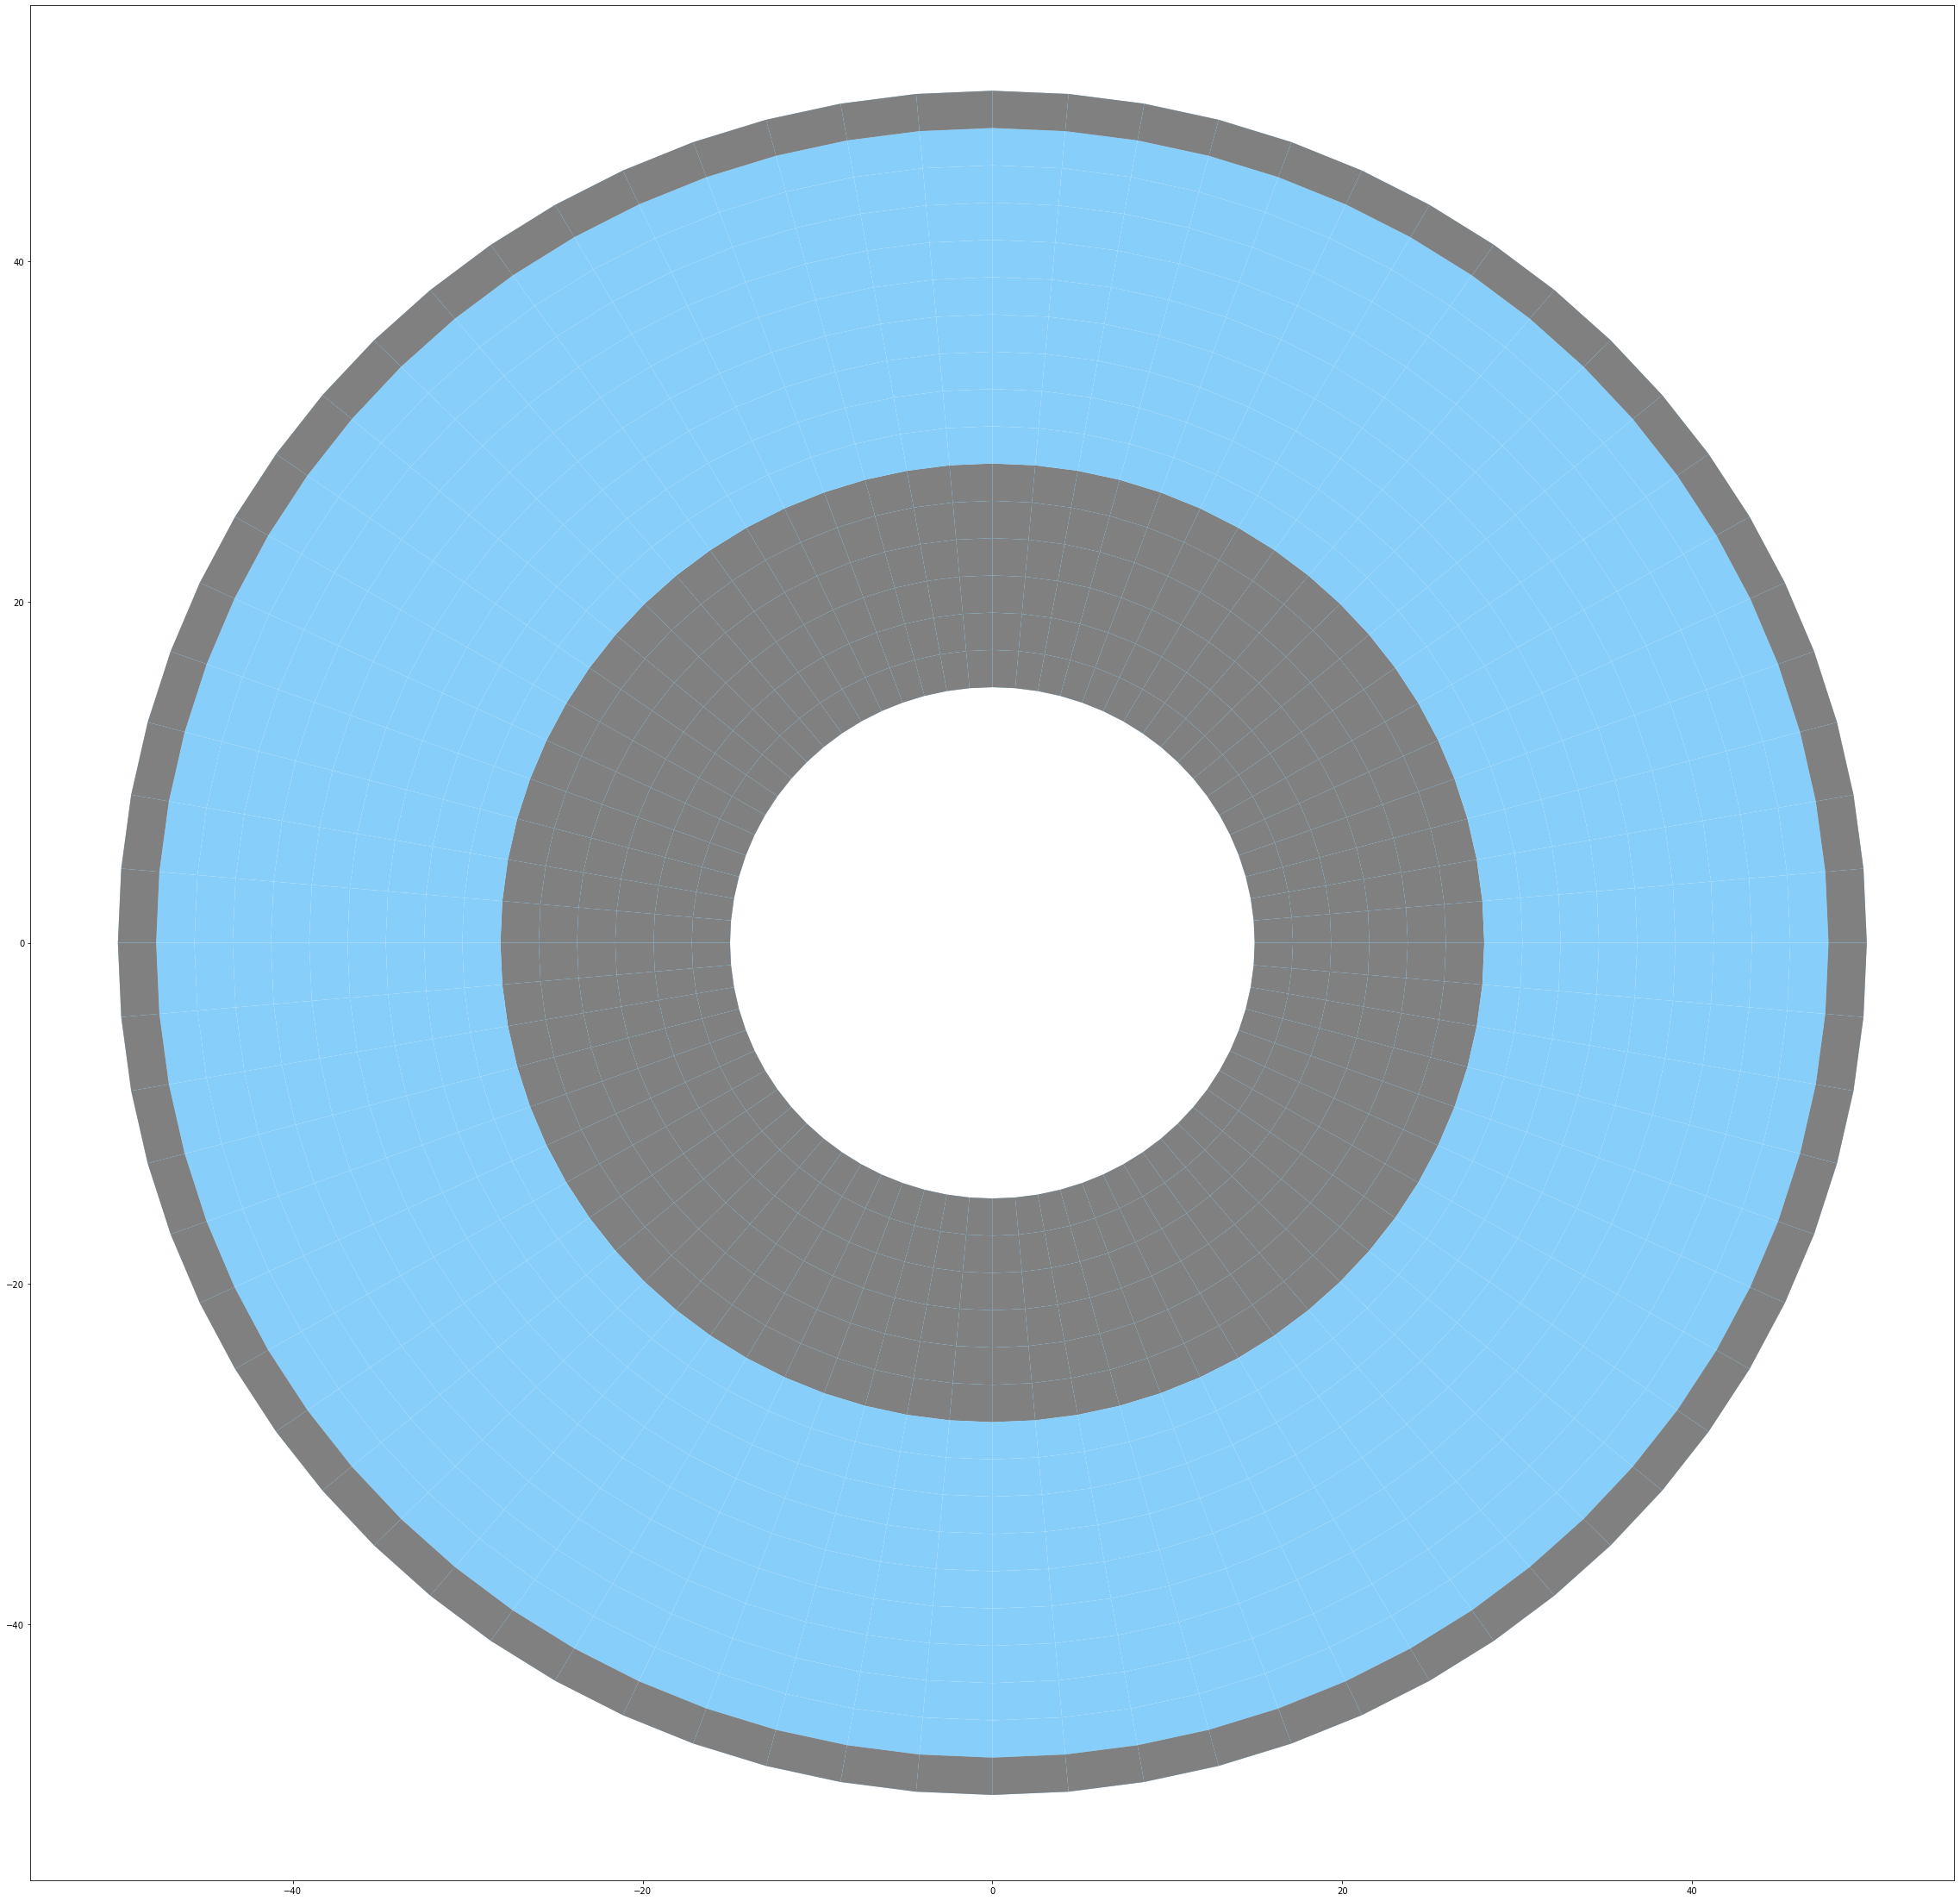

In [10]:
for i in range(((N-1)*thetasteps)):
    xs,ys=zip(*ele[i])
    #plt.plot(xs,ys,color='red')
    plt.fill(xs, ys, "lightskyblue")   
    #if(i in rubber):
    #    xs,ys=zip(*ele[i])
    #    plt.fill(xs, ys, "darksalmon")
    if(i in metal):
        xs,ys=zip(*ele[i])
        plt.fill(xs, ys, "gray")
        #plt.plot(xs,ys)

**Parameter defenitions**  8 parameters [IRp1,r1,θ1,ORp1,IRp2,r2,θ2,ORp2] 


- IRp1 = [0-17]
-IRp2 = [0-17]
-r1 =  [0-16]
-θ1 = [0-90]
-ORp1 = [0-17]
-ORp2 = [0-17]
-r2 =  [0-16]
-θ2 = [0-90]


In [34]:
%matplotlib
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, (math.degrees(phi)+360)%360)

def pol2cart(rho, phi):
    x = rho * np.cos(math.radians(phi))
    y = rho * np.sin(math.radians(phi))
    return([x, y])


r1=r[2]
r2=r[14]
theta1=math.degrees(theta[0])
theta2=math.degrees(theta[10])


cordinate_list=[]

xs=[]
ys=[]
count=0

#visualizing just the first quadrant elements 
for i in range((N-1)*thetasteps):
    counter=0
    for j in range(4):
        counter=counter+1
        if(counter==4):
            xs,ys=zip(*ele[i])
            plt.plot(xs,ys,color='gray')
            x_avg=xs[0]+xs[1]+xs[2]+xs[3]
            y_avg=ys[0]+ys[1]+ys[2]+ys[3]
            cordinate_list.append(([(xs[0]),(ys[0])]))

#parameter=[irp1, r1, t1, opr1, irp2, r2, t2, orp2]

#parameter=[5,8,5,2,7,5,60,10]  #both curved
parameter=[0,0,0,0,18,0,0,18]   #2 is line
#parameter=[5,0,0,2,10,0,0,10]   #1 is line

a,b = zip(*cordinate_list)
plt.scatter(a,b,color='red')


polygon_list=[]


Geo_config=[0,0,0,0]

#if 1 is line
if (parameter[1]==0 and parameter[2]==0):
    Geo_config[0]=1
    polygon_list.append([cordinate_list[parameter[0]]])
    #polygon_list.append([cordinate_list[(N-2)*thetasteps+parameter[3]]])
    rads,thets=cart2pol(cordinate_list[(N-2)*thetasteps+parameter[3]][0],cordinate_list[(N-2)*thetasteps+parameter[3]][1])
    print(pol2cart(rads+20,thets))
    polygon_list.append([pol2cart(rads+20,thets)])
    
#if 1 is curve
if (parameter[1]!=0 and parameter[2]!=0):
    Geo_config[1]=1
    polygon_list.append([cordinate_list[parameter[0]]])
    polygon_list.append([cordinate_list[int(thetasteps*(parameter[1]-1)+parameter[2]/(360/thetasteps))]])
    rads,thets=cart2pol(cordinate_list[(N-2)*thetasteps+parameter[3]][0],cordinate_list[(N-2)*thetasteps+parameter[3]][1])
    print(pol2cart(rads+20,thets))
    polygon_list.append([pol2cart(rads+20,thets)])
    #polygon_list.append([cordinate_list[(N-2)*thetasteps+parameter[3]]])

#if 2 is line
if(parameter[5]==0 and parameter[6]==0):
    Geo_config[2]=1
    #polygon_list.append([cordinate_list[(N-2)*thetasteps+parameter[7]]]) 
    rads,thets=cart2pol(cordinate_list[(N-2)*thetasteps+parameter[7]][0],cordinate_list[(N-2)*thetasteps+parameter[7]][1])
    print(pol2cart(rads+20,thets))
    polygon_list.append([pol2cart(rads+20,thets)])
    
    polygon_list.append([cordinate_list[parameter[4]]])

#if 2 is curve
if(parameter[5]!=0 and parameter[6]!=0):
    Geo_config[3]=1
    #polygon_list.append([cordinate_list[(N-2)*thetasteps+parameter[7]]])
    rads,thets=cart2pol(cordinate_list[(N-2)*thetasteps+parameter[7]][0],cordinate_list[(N-2)*thetasteps+parameter[7]][1])
    print(pol2cart(rads+20,thets))
    polygon_list.append([pol2cart(rads+20,thets)])
    polygon_list.append([cordinate_list[int(thetasteps*(parameter[5]-1)+parameter[6]/(360/thetasteps))]])
    polygon_list.append([cordinate_list[parameter[4]]])

    

    
polygon_list.append(polygon_list[0])



#print([cordinate_list[parameter[0]]]) #irp1
#print([cordinate_list[parameter[4]]])  #irp2
#print([cordinate_list[int(thetasteps*(parameter[1]-1)+parameter[2]/(360/thetasteps))]])  #r1, theta1
#print([[[cordinate_list[(N-2)*thetasteps+parameter[7]]][0][0]+20,[cordinate_list[(N-2)*thetasteps+parameter[7]]][0][1]]]) #orp2
#print([[[cordinate_list[(N-2)*thetasteps+parameter[3]]][0][0]+20,[cordinate_list[(N-2)*thetasteps+parameter[3]]][0][1]]]) #orp1
#print([cordinate_list[int(thetasteps*(parameter[5]-1)+parameter[6]/(360/thetasteps))]])  #r2, theta2

print(Geo_config)

polygon1=[]
polygon2=[]
polygon3=[]
polygon4=[]

for x in polygon_list:
    polygon1.append((round(x[0][0],2),round(x[0][1],2)))
    polygon2.append((round(-x[0][0],2),round(x[0][1],2)))
    polygon3.append((round(-x[0][0],2),round(-x[0][1],2)))
    polygon4.append((round(x[0][0],2),round(-x[0][1],2)))

#Visualizing the polygon formed only in first quadrant
plt.plot(*zip(*polygon1),color='k')
plt.plot(*zip(*polygon2),color='k')
plt.plot(*zip(*polygon3),color='k')
plt.plot(*zip(*polygon4),color='k')


#print([[[cordinate_list[(N-2)*thetasteps+parameter[7]]][0][0]+20,[cordinate_list[(N-2)*thetasteps+parameter[7]]][0][1]]])

#print([cordinate_list[(N-2)*thetasteps+parameter[7]]])

#plt.show()




polygon1 = Polygon(polygon1)
polygon2 = Polygon(polygon2)
polygon3 = Polygon(polygon3)
polygon4 = Polygon(polygon4)


plt.savefig("2D_cross_sec_images/circle_insert/"+fil_name+"_polygon_view.png")






#print(cart2pol(polygon_list[3][0][0],polygon_list[3][0][1]),cart2pol(polygon_list[4][0][0],polygon_list[4][0][1]))



Using matplotlib backend: Qt5Agg
[67.8125, 0.0]
[4.152318053358994e-15, 67.8125]
[1, 0, 1, 0]


In [32]:
rubber=[]

for i in range(len(ele)):
    p1_counter=p2_counter=p3_counter=p4_counter=0
    for j in range(4):
        if(i in metal):
            pass
        else:
            if(polygon1.contains(Point(ele[i][j][0], ele[i][j][1]))): 
                p1_counter=p1_counter+1
                if(p1_counter==2):
                    rubber.append(i)
            if(polygon2.contains(Point(ele[i][j][0], ele[i][j][1]))): 
                p2_counter=p2_counter+1
                if(p2_counter==2):
                    rubber.append(i)
            if(polygon3.contains(Point(ele[i][j][0], ele[i][j][1]))): 
                p3_counter=p3_counter+1
                if(p3_counter==2):
                    rubber.append(i)
            if(polygon4.contains(Point(ele[i][j][0], ele[i][j][1]))): 
                p4_counter=p4_counter+1
                if(p4_counter==2):
                    rubber.append(i)

In [42]:
#fill up remaining r,theta 

In [33]:
#%matplotlib
for i in range(((N-1)*thetasteps)):
    xs,ys=zip(*ele[i])
    #plt.plot(xs,ys,color='red')
    plt.fill(xs, ys, "lightskyblue")   
    if(i in rubber):
        xs,ys=zip(*ele[i])
        plt.fill(xs, ys, "darksalmon")
    if(i in metal):
        xs,ys=zip(*ele[i])
        plt.fill(xs, ys, "gray")
        #plt.plot(xs,ys)

plt.rcParams['figure.figsize'] = [40, 40]

fil_name="test"
plt.axis('off')
#plt.savefig("2D_cross_sec_images/circle_insert/"+fil_name+".svg")


plt.show()

In [14]:
#%matplotlib
#rubber=[]


'''

for i in range(len(ele)):
    counter=0
    for j in range(4):
        #if(ele[i][j][0]>0 and ele[i][j][1]>0):
        #    xs,ys=zip(*ele[i])
        #    plt.plot(xs,ys,color='green')
        if(i not in metal):
            if(polygon.contains(Point(ele[i][j][0], ele[i][j][1]))):  #  ele[i][j][0]>=0 and ele[i][j][1]>=0):
                counter=counter+1
                if(counter==4):
                    xs,ys=zip(*ele[i])
                    plt.plot(xs,ys,color='magenta')
                    rubber.append(i)


plt.plot([x[0][0] for x in polygon_list],[x[0][1] for x in polygon_list],color='black')
plt.plot([x[0] for x in metal_polygon],[x[1] for x in metal_polygon],color='black')
plt.plot(*polygon.exterior.xy)


plt.show()


'''

"\n\nfor i in range(len(ele)):\n    counter=0\n    for j in range(4):\n        #if(ele[i][j][0]>0 and ele[i][j][1]>0):\n        #    xs,ys=zip(*ele[i])\n        #    plt.plot(xs,ys,color='green')\n        if(i not in metal):\n            if(polygon.contains(Point(ele[i][j][0], ele[i][j][1]))):  #  ele[i][j][0]>=0 and ele[i][j][1]>=0):\n                counter=counter+1\n                if(counter==4):\n                    xs,ys=zip(*ele[i])\n                    plt.plot(xs,ys,color='magenta')\n                    rubber.append(i)\n\n\nplt.plot([x[0][0] for x in polygon_list],[x[0][1] for x in polygon_list],color='black')\nplt.plot([x[0] for x in metal_polygon],[x[1] for x in metal_polygon],color='black')\nplt.plot(*polygon.exterior.xy)\n\n\nplt.show()\n\n\n"

In [15]:
'''
rubber=[]


pol1 = Polygon(polygon1)
pol2 = Polygon(polygon2)
pol3 = Polygon(polygon3)
pol4 = Polygon(polygon4)

plt.figure(2)
for i in range((N-1)*thetasteps):
    counter=0
    for j in range(4):
    
        xs,ys=zip(*ele[i])
        plt.plot(xs,ys,color='green')
        if(i not in metal):
            if(pol1.contains(Point(ele[i][j][0], ele[i][j][1])) or pol2.contains(Point(ele[i][j][0], ele[i][j][1])) or pol3.contains(Point(ele[i][j][0], ele[i][j][1])) or pol4.contains(Point(ele[i][j][0], ele[i][j][1]))):  #  ele[i][j][0]>=0 and ele[i][j][1]>=0):
                counter=counter+1
                if(counter==4):
                    xs,ys=zip(*ele[i])
                    plt.plot(xs,ys,color='magenta')
                    rubber.append(i)

plt.show()
'''

"\nrubber=[]\n\n\npol1 = Polygon(polygon1)\npol2 = Polygon(polygon2)\npol3 = Polygon(polygon3)\npol4 = Polygon(polygon4)\n\nplt.figure(2)\nfor i in range((N-1)*thetasteps):\n    counter=0\n    for j in range(4):\n    \n        xs,ys=zip(*ele[i])\n        plt.plot(xs,ys,color='green')\n        if(i not in metal):\n            if(pol1.contains(Point(ele[i][j][0], ele[i][j][1])) or pol2.contains(Point(ele[i][j][0], ele[i][j][1])) or pol3.contains(Point(ele[i][j][0], ele[i][j][1])) or pol4.contains(Point(ele[i][j][0], ele[i][j][1]))):  #  ele[i][j][0]>=0 and ele[i][j][1]>=0):\n                counter=counter+1\n                if(counter==4):\n                    xs,ys=zip(*ele[i])\n                    plt.plot(xs,ys,color='magenta')\n                    rubber.append(i)\n\nplt.show()\n"

In [16]:
'''
c1 = sympy.Circle(sympy.Point(0, 0), r[rad_val])
spolygon=sympy.Polygon(*mapping(polygon)['coordinates'][0])
print((c1.intersection(spolygon)[0]),(c1.intersection(spolygon)[1]))

figure, axes = plt.subplots()
draw_circle = plt.Circle((0, 0), r[rad_val])

axes.set_aspect(1)
axes.add_artist(draw_circle)
plt.title('Circle')

plt.scatter(c1.intersection(spolygon)[0][0],(c1.intersection(spolygon)[0][1]),s=250,c='red')
plt.scatter(c1.intersection(spolygon)[1][0],(c1.intersection(spolygon)[1][1]),s=250,c='red')
plt.plot([x[0][0] for x in polygon_list],[x[0][1] for x in polygon_list],color='black')

plt.show()

'''

"\nc1 = sympy.Circle(sympy.Point(0, 0), r[rad_val])\nspolygon=sympy.Polygon(*mapping(polygon)['coordinates'][0])\nprint((c1.intersection(spolygon)[0]),(c1.intersection(spolygon)[1]))\n\nfigure, axes = plt.subplots()\ndraw_circle = plt.Circle((0, 0), r[rad_val])\n\naxes.set_aspect(1)\naxes.add_artist(draw_circle)\nplt.title('Circle')\n\nplt.scatter(c1.intersection(spolygon)[0][0],(c1.intersection(spolygon)[0][1]),s=250,c='red')\nplt.scatter(c1.intersection(spolygon)[1][0],(c1.intersection(spolygon)[1][1]),s=250,c='red')\nplt.plot([x[0][0] for x in polygon_list],[x[0][1] for x in polygon_list],color='black')\n\nplt.show()\n\n"

The below logic will be modified 

In [17]:
'''
rubber_lis=[]


                
for i in range(len(e_list)):
    if i in metal:
        continue
    for j in range(len(rubber)):
        
        ra,th=polar1(nodes[e_list[i][1]-1][1],nodes[e_list[i][1]-1][2])
        rub_r,rub_th=polar1(nodes[e_list[rubber[j]][1]-1][1],nodes[e_list[rubber[j]][1]-1][2])
        if((ra==rub_r) and (th== rub_th or th==180-(rub_th+360/thetasteps) or th==180+rub_th or th==360-(rub_th+360/thetasteps))):
       
            rubber_lis.append(i)
            
#print(rubber_lis,len(rubber_lis))

'''




'\nrubber_lis=[]\n\n\n                \nfor i in range(len(e_list)):\n    if i in metal:\n        continue\n    for j in range(len(rubber)):\n        \n        ra,th=polar1(nodes[e_list[i][1]-1][1],nodes[e_list[i][1]-1][2])\n        rub_r,rub_th=polar1(nodes[e_list[rubber[j]][1]-1][1],nodes[e_list[rubber[j]][1]-1][2])\n        if((ra==rub_r) and (th== rub_th or th==180-(rub_th+360/thetasteps) or th==180+rub_th or th==360-(rub_th+360/thetasteps))):\n       \n            rubber_lis.append(i)\n            \n#print(rubber_lis,len(rubber_lis))\n\n'

In [18]:
'''
#removing replica entries in rubber_lis
lis=(np.unique(np.array(rubber)))
print(len(lis),len(rubber))
'''

'\n#removing replica entries in rubber_lis\nlis=(np.unique(np.array(rubber)))\nprint(len(lis),len(rubber))\n'

In [19]:
'''
for i in range(len(ele)):
    xs,ys=zip(*ele[i])
    plt.plot(xs,ys,color='blue')
    if(i in lis):
        xs,ys=zip(*ele[i])
        plt.plot(xs,ys,color='yellow')
    if(i in metal):
        xs,ys=zip(*ele[i])
        plt.plot(xs,ys,color='magenta')
    

    
#visualizing the final geometry in 2D
plt.plot([-40,40],[0,0],color='black')
plt.plot([0,0],[-40,40],color='black')
plt.show()
'''

"\nfor i in range(len(ele)):\n    xs,ys=zip(*ele[i])\n    plt.plot(xs,ys,color='blue')\n    if(i in lis):\n        xs,ys=zip(*ele[i])\n        plt.plot(xs,ys,color='yellow')\n    if(i in metal):\n        xs,ys=zip(*ele[i])\n        plt.plot(xs,ys,color='magenta')\n    \n\n    \n#visualizing the final geometry in 2D\nplt.plot([-40,40],[0,0],color='black')\nplt.plot([0,0],[-40,40],color='black')\nplt.show()\n"

In [13]:
#lis=(np.unique(np.array(rubber)))

f = open("Test_insert_testing_final.inp", "w")
f.write("**\n*HEADING\n**\n**\n**\n**\n*NODE\n")

#write nodes first with node number and x,y,z cordinates
for i in range(len(nodes)):
    f.write(str(nodes[i][0])+",\t"+str(nodes[i][1])+",\t"+str(nodes[i][2])+",\t"+str(nodes[i][3])+"\n")
    
#start specifying solid elements     
f.write("**\n** SOLID ELEMENTS\n**\n")
    
    
f.write("*ELEMENT, TYPE=C3D8H, ELSET=SOLID_RUBBER\n")
for i in range(len(rubber)):
    f.write(str(e_list[rubber[i]][0])+",\t"+
            str(e_list[rubber[i]][1])+",\t"+
            str(e_list[rubber[i]][4])+",\t"+
            str(e_list[rubber[i]][3])+",\t"+
            str(e_list[rubber[i]][2])+",\t"+
            str(e_list[rubber[i]][5])+",\t"+
            str(e_list[rubber[i]][8])+",\t"+
            str(e_list[rubber[i]][7])+",\t"+
            str(e_list[rubber[i]][6])+"\n")


f.write("*ELEMENT, TYPE=C3D8, ELSET=SOLID_METAL\n")
for i in range(len(metal)):
    f.write(str(e_list[metal[i]][0])+",\t"+
            str(e_list[metal[i]][1])+",\t"+
            str(e_list[metal[i]][4])+",\t"+
            str(e_list[metal[i]][3])+",\t"+
            str(e_list[metal[i]][2])+",\t"+
            str(e_list[metal[i]][5])+",\t"+
            str(e_list[metal[i]][8])+",\t"+
            str(e_list[metal[i]][7])+",\t"+
            str(e_list[metal[i]][6])+"\n")



The static part of the file which remains constant for all geometeries 

In [14]:
f_1 = open("static_text_for_inp_with_MPC.txt", "r")
f.write(f_1.read())
f.close()